# Visualization Notebook: Figures for the Master's Thesis

Figures that were not produced with QGIS are included in this notebook. The outputs are found in the master thesis itself.

### Chapter Data: Mapillary

✅ Temporal distribution plot saved as temporal_distribution_mapillary_zurich.jpg


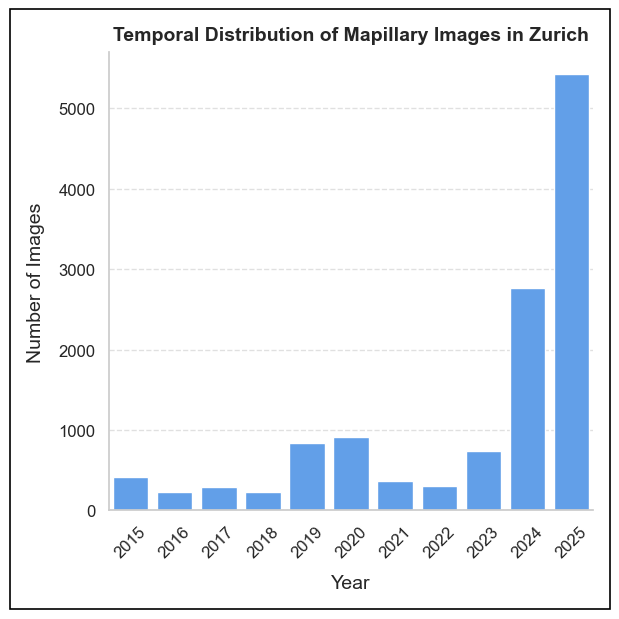

c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)


✅ Hexgrid saved as mapillary_hexgrid_counts.gpkg (no holes, full bbox)


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import numpy as np
import math
from shapely.geometry import Polygon
import geohexgrid as ghg
import matplotlib.patches as mpatches


# -----------------------------
# Load & preprocess data
# -----------------------------
gdf = gpd.read_file(
    r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_0_Fetch_Mapillary\data\images_bbox_fullmeta_with_blur_red.gpkg"
)

# Convert timestamp (epoch in ms -> datetime)
gdf["captured_at"] = pd.to_datetime(gdf["captured_at_x"], unit="ms")

# Filter: only from 2015 onwards
gdf = gdf[gdf["captured_at"] >= "2015-01-01"]

# -----------------------------
# 1) Temporal distribution
# -----------------------------
gdf["year"] = gdf["captured_at"].dt.year
counts = gdf["year"].value_counts().sort_index()

df_plot = counts.reset_index()
df_plot.columns = ["year", "count"]

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 6))  # etwas breiter, besseres Verhältnis

sns.barplot(
    data=df_plot,
    x="year",
    y="count",
    color="#4C9DFE",
    ax=ax,
)
ax.set_title(
    "Temporal Distribution of Mapillary Images in Zurich",
    fontsize=14, fontweight="bold", pad=9
)
ax.set_xlabel("Year", fontsize=14, labelpad=10)
ax.set_ylabel("Number of Images", fontsize=14, labelpad=10)

ax.tick_params(axis="x", labelsize=12, rotation=45)
ax.tick_params(axis="y", labelsize=12)

ax.grid(axis="y", linestyle="--", alpha=0.6)
sns.despine(left=False, bottom=False)

# -----------------------------
# Add frame around entire figure
# -----------------------------
rect = mpatches.Rectangle(
    (0, 0), 1, 1, transform=fig.transFigure,
    fill=False, color="black", linewidth=1.2
)
fig.patches.append(rect)

plt.tight_layout(pad=1)
plt.savefig("temporal_distribution_mapillary_zurich.jpg", dpi=300, bbox_inches="tight")
print("✅ Temporal distribution plot saved as temporal_distribution_mapillary_zurich.jpg")
plt.show()

# -----------------------------
# 2) Spatial hexgrid with counts
# -----------------------------
def make_hexgrid_with_counts(points_gdf, ref_gpkg_path, radius=200):
    """
    Create a hexagonal grid from a reference feature (GeoPackage).
    Count the points per hexagon and return the hex grid.
    """
    # Punkte nach Web Mercator (Meter) projizieren
    points_gdf = points_gdf.to_crs(epsg=3857)

    # Referenzfläche laden (z.B. Stadt-/Gemeindegrenzen)
    ref_gdf = gpd.read_file(ref_gpkg_path)
    ref_gdf = ref_gdf.to_crs(epsg=3857)

    # Hexgrid über die Referenzfläche spannen (nimmt deren bounding box)
    hex_gdf = ghg.make_grid_from_gdf(ref_gdf, R=radius)

    # Hexgrid auf die tatsächliche Referenzfläche beschneiden
    hex_gdf = gpd.overlay(hex_gdf, ref_gdf, how="intersection")

    # Punkte den Hex-Zellen zuordnen
    joined = gpd.sjoin(points_gdf, hex_gdf, predicate="within")

    # Punkte pro Hex zählen
    counts = joined.groupby("index_right").size()
    hex_gdf["count"] = counts.reindex(hex_gdf.index, fill_value=0)

    # Log-Skala hinzufügen
    hex_gdf["count_log"] = np.log1p(hex_gdf["count"])

    return hex_gdf


# Create full hex grid with counts
hex_gdf = make_hexgrid_with_counts(
    gdf,
    ref_gpkg_path=r"D:\Masterarbeit\05_Masterarbeit\Figures_Python\hoheitsgebiet.gpkg",
    radius=150
)
# Export to GeoPackage
hex_gdf.to_file("mapillary_hexgrid_counts.gpkg", driver="GPKG")
print("✅ Hexgrid saved as mapillary_hexgrid_counts.gpkg (no holes, full bbox)")


In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams

# Set font
rcParams["font.family"] = "Microsoft Sans Serif"

# -----------------------------
# Final labels (logarithmic bins) and colors
# -----------------------------
labels = [
    "0",
    "<0 – 2",
    "<2 – 6",
    "<6 – 16",
    "<16 – 42",
    "<42 – 109",
    "<109 – 279",
    "<279"
]

custom_colors = [
    "#ffffdf",
    "#ffefc6",
    "#ffdfb4",
    "#ffcfad",
    "#feb5a6",
    "#f49fa0",
    "#df94a4",
    "#df94a4"
]

# Class patches
class_patches = [
    mpatches.Patch(color=c, label=l)
    for c, l in zip(custom_colors, labels)
]

# City of Zurich patch
city_patch = mpatches.Patch(
    facecolor="white",
    edgecolor="black",
    linewidth=1,
    linestyle="--",
    label="City of Zurich"
)

# -----------------------------
# Legend 1: City of Zurich
# -----------------------------
fig, ax = plt.subplots(figsize=(2, 1.5))
ax.axis("off")

ax.legend(
    handles=[city_patch],
    loc="center",
    frameon=False
)

plt.savefig("legend_city_of_zurich.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.close()

# -----------------------------
# Legend 2: Mapillary Images
# -----------------------------
fig, ax = plt.subplots(figsize=(2.5, 3.5))
ax.axis("off")

ax.legend(
    handles=class_patches,
    title="Number of\nMapillary Images",
    loc="center",
    frameon=False
)

plt.savefig("legend_mapillary.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.close()

print("✅ Both legends saved: legend_city_of_zurich.png & legend_mapillary.png")


✅ Both legends saved: legend_city_of_zurich.png & legend_mapillary.png


### Chapter Methodology: YOLO Predictions

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from collections import Counter
import colorsys

# --- Einstellungen ---
model_path = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\models\M4.pt"
model = YOLO(model_path)
img_folder = r"D:\Masterarbeit\05_Masterarbeit\Kapitel\5_Results\img\Models_mapillary\img"
output_folder = r"D:\Masterarbeit\05_Masterarbeit\Kapitel\5_Results\img\Models_mapillary\img_output"
os.makedirs(output_folder, exist_ok=True)

conf_threshold = 0.2

# Farben für Klassen zwischenspeichern
class_colors = {}

def color_for_class(cls_id, total_classes=20):
    """Erzeugt stabile, gut unterscheidbare Farben für jede Klassen-ID (Goldener-Winkel-Methode)."""
    if cls_id not in class_colors:
        golden_angle = 137.508
        hue = ((cls_id * golden_angle) % 360) / 360.0
        r, g, b = colorsys.hsv_to_rgb(hue, 0.85, 0.95)
        class_colors[cls_id] = (int(r * 255), int(g * 255), int(b * 255))
    return class_colors[cls_id]


# --- Vorhersagen ---
results = model.predict(source=img_folder, conf=0.25, imgsz=640, save=False)

for r in results:
    base_name = os.path.basename(r.path)
    mapillary_id = os.path.splitext(base_name)[0]

    img = cv2.imread(r.path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    boxes_only = img.copy()
    masks_only = np.zeros_like(img)
    cls_counts = Counter()
    total_classes = len(r.names)

    # Boxen & Masken
    for box, cls, conf, mask in zip(r.boxes.xyxy, r.boxes.cls, r.boxes.conf, r.masks.data):
        cls = int(cls.item())
        conf = float(conf.item())
        cls_counts[cls] += 1
        color = color_for_class(cls, total_classes)

        # Maske
        mask_resized = cv2.resize(mask.cpu().numpy().astype(np.uint8), (w, h))
        colored_mask = np.zeros_like(img)
        colored_mask[:] = color
        masks_only = cv2.addWeighted(
            masks_only, 1.0, colored_mask * mask_resized[:, :, None], 0.7, 0
        )

        # Boxen
        if conf >= conf_threshold:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(boxes_only, (x1, y1), (x2, y2), color, 2)

            label = f"{r.names[cls]} {conf:.1f}"
            pos = (x1, max(y1 - 5, 15))
            cv2.putText(boxes_only, label, pos,
                        cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 2, lineType=cv2.LINE_AA)
            cv2.putText(boxes_only, label, pos,
                        cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1, lineType=cv2.LINE_AA)

    # --- Figure ---
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

    # Panels
    panels = [
        ("Original", img, (0, 0)),
        ("Predicted Boxes (conf > 0.2)", boxes_only, (0, 1)),
        ("Predicted Segmentation", masks_only, (1, 0))
    ]

    for title, image, pos in panels:
        ax = fig.add_subplot(gs[pos])
        ax.imshow(image)
        ax.set_title(f"{title} (Img_ID: {mapillary_id})" if title == "Original" else title,
                     fontsize=16, fontweight="bold", pad=10)
        ax.axis("off")

    # Legende unten rechts
    ax_leg = fig.add_subplot(gs[1, 1])
    ax_leg.axis("off")

    ax_leg.text(
        0.5, 1, "Legend",
        fontsize=18, fontweight="bold",
        ha="center", va="bottom",
        transform=ax_leg.transAxes
    )

    patches = []
    for cls in sorted(cls_counts.keys()):
        color = np.array(color_for_class(cls, total_classes)) / 255.0
        label = f"{r.names[cls]} ({cls_counts[cls]})"
        patches.append(mpatches.Patch(color=color, label=label))

    if patches:
        ax_leg.legend(
            handles=patches,
            loc="center",
            ncol=1,
            fontsize=14,
            frameon=False
        )

    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    out_path = os.path.join(output_folder, base_name)
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    plt.close()

print(f"✅ All figures saved in {output_folder}")



image 1/1 D:\Masterarbeit\05_Masterarbeit\Figures_Python\images\651146617626059.jpg: 512x640 1 construction--barrier--curb, 1 construction--flat--road, 1 construction--structure--building, 5 human--person--individuals, 1 nature--sky, 2 object--support--poles, 2 object--traffic-sign--fronts, 1 object--vehicle--bicycle, 2 object--vehicle--cars, 1 object--vehicle--truck, 1 void--ego-vehicle, 53.5ms
Speed: 7.1ms preprocess, 53.5ms inference, 8.9ms postprocess per image at shape (1, 3, 512, 640)
✅ All figures saved in D:\Masterarbeit\05_Masterarbeit\Figures_Python\images\output


In [26]:
# %% [markdown]
# YOLO training curves: multi-run comparison (e.g., Baseline, Fine-tuned, Nano)

from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# -------------------------
# 1) Add as many runs as you like here
# -------------------------
RUNS = {
    "Street-Level–Model 1": r"./results_yolo/results1.csv",
    "Street-Level–Model 2": r"./results_yolo/results_finetune.csv",
    "Street-Level–Model 3": r"./results_yolo/results_finetune2.csv",
    "Street-Level–Model 4": r"./results_yolo/results_nano.csv",
}

OUTDIR = r"./results_yolo/learning_curves_multi"
Path(OUTDIR).mkdir(parents=True, exist_ok=True)

# -------------------------
# 2) Load all CSVs
# -------------------------
dfs = {}
for name, path in RUNS.items():
    df = pd.read_csv(path)
    dfs[name] = df

# -------------------------
# 3) Find common metrics across ALL runs
# -------------------------
candidates = [
    "train/box_loss","train/cls_loss","train/seg_loss",
    "val/box_loss","val/cls_loss","val/seg_loss",
    "metrics/precision","metrics/recall","metrics/mAP50","metrics/mAP50-95"
]
common_metrics = set(candidates)
for df in dfs.values():
    common_metrics &= set(df.columns)
common_metrics = [m for m in candidates if m in common_metrics]
if not common_metrics:
    raise ValueError("No common metrics across all runs. Check your CSVs.")

# Helper: x-axis for each run
def x_axis(df):
    return df["epoch"] if "epoch" in df.columns else range(1, len(df)+1)

# -------------------------
# 4) Plot & save each metric
# -------------------------
saved_paths = []
for m in common_metrics:
    plt.figure(figsize=(6,4))
    for name, df in dfs.items():
        plt.plot(x_axis(df), df[m], marker='o', label=name)
    plt.title(m)
    plt.xlabel("Epoch")
    plt.ylabel(m)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    fname = m.replace("/", "_") + ".jpg"
    fpath = os.path.join(OUTDIR, fname)
    plt.savefig(fpath, dpi=200)
    plt.close()
    saved_paths.append(fpath)

print("Saved individual plots to:", OUTDIR)

# -------------------------
# 5) Composite: all six standard losses (2x3) if available
# -------------------------
all_order = [
    "train_box_loss.jpg","train_cls_loss.jpg","train_seg_loss.jpg",
    "val_box_loss.jpg","val_cls_loss.jpg","val_seg_loss.jpg"
]
all_paths = [os.path.join(OUTDIR, f) for f in all_order if os.path.exists(os.path.join(OUTDIR, f))]

if all_paths and len(all_paths) == 6:
    imgs = [Image.open(p).convert("RGB") for p in all_paths]
    w, h = imgs[0].size
    cols, rows = 3, 2
    canvas = Image.new("RGB", (cols*w, rows*h), (255,255,255))
    for idx, im in enumerate(imgs):
        r, c = divmod(idx, cols)
        canvas.paste(im, (c*w, r*h))
    composite_all = os.path.join(OUTDIR, "yolo_training_curves.jpg")
    canvas.save(composite_all)
    print("Composite (all 6):", composite_all)
else:
    composite_all = None
    print("Note: Not all six loss plots available; skipping all-loss composite.")

# -------------------------
# 6) Composite: validation-only (1x3) if available
# -------------------------
val_order = ["val_box_loss.jpg","val_cls_loss.jpg","val_seg_loss.jpg"]
val_paths = [os.path.join(OUTDIR, f) for f in val_order if os.path.exists(os.path.join(OUTDIR, f))]

if val_paths and len(val_paths) == 3:
    imgs = [Image.open(p).convert("RGB") for p in val_paths]
    w, h = imgs[0].size
    cols, rows = 3, 1
    canvas = Image.new("RGB", (cols*w, rows*h), (255,255,255))
    for idx, im in enumerate(imgs):
        canvas.paste(im, (idx*w, 0))
    composite_val = os.path.join(OUTDIR, "yolo_training_curves_val.jpg")
    canvas.save(composite_val)
    print("Composite (validation only):", composite_val)
else:
    composite_val = None
    print("Note: Validation loss plots not complete; skipping val composite.")

# -------------------------
# 7) Compact summary table (start/end per metric & run)
# -------------------------
def first_last(series):
    return series.iloc[0], series.iloc[-1]

rows = []
for m in common_metrics:
    row = {"Metric": m}
    for name, df in dfs.items():
        s0, sN = first_last(df[m])
        row[f"Start {name}"] = s0
        row[f"End {name}"] = sN
    rows.append(row)

summary = pd.DataFrame(rows)
display(summary.round(5))

# Optional: also show epoch counts per run
epoch_info = []
for name, df in dfs.items():
    if "epoch" in df.columns:
        e_min, e_max = int(df["epoch"].iloc[0]), int(df["epoch"].iloc[-1])
        n_epochs = len(df)
    else:
        e_min, e_max = 1, len(df)
        n_epochs = len(df)
    epoch_info.append({"Run": name, "Rows": n_epochs, "Epoch first": e_min, "Epoch last": e_max})
display(pd.DataFrame(epoch_info))


Saved individual plots to: ./results_yolo/learning_curves_multi
Composite (all 6): ./results_yolo/learning_curves_multi\yolo_training_curves.jpg
Composite (validation only): ./results_yolo/learning_curves_multi\yolo_training_curves_val.jpg


,Metric,Start Street-Level–Model 1,End Street-Level–Model 1,Start Street-Level–Model 2,End Street-Level–Model 2,Start Street-Level–Model 3,End Street-Level–Model 3,Start Street-Level–Model 4,End Street-Level–Model 4
0,train/box_loss,1.85023,1.11582,1.43192,1.21939,1.25737,1.17872,1.34162,1.19372
1,train/cls_loss,5.21004,1.27411,1.83359,1.26936,1.33816,1.17822,1.62193,1.14598
2,train/seg_loss,5.01066,2.69171,3.15181,2.72380,2.79645,2.62245,3.22856,2.60354
3,val/box_loss,2.13520,1.54598,1.39384,1.27458,1.26906,1.18474,1.47801,1.22166
4,val/cls_loss,5.07841,1.91759,1.61220,1.31696,1.30095,1.15168,1.60814,1.16320
5,val/seg_loss,4.71271,3.39497,3.02942,2.77559,2.75640,2.58288,3.14553,2.62290


,Run,Rows,Epoch first,Epoch last
0,Street-Level–Model 1,36,1,36
1,Street-Level–Model 2,10,1,10
2,Street-Level–Model 3,9,2,10
3,Street-Level–Model 4,100,1,100


### Chapter Methodology: Depth

In [4]:
import torch
from transformers import pipeline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob, os

# --- Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe_small = pipeline(
    "depth-estimation",
    model="depth-anything/Depth-Anything-V2-Small-hf",
    device=0 if device == "cuda" else -1
)

pipe_large = pipeline(
    "depth-estimation",
    model="depth-anything/Depth-Anything-V2-Large-hf",
    device=0 if device == "cuda" else -1
)


# --- Helper: Depth array from pipeline ---
def get_depth_array(pipe, image):
    with torch.no_grad():
        depth_output = pipe(image)["depth"]

    if isinstance(depth_output, torch.Tensor):
        return depth_output.cpu().numpy()
    elif isinstance(depth_output, Image.Image):
        return np.array(depth_output, dtype=np.float32)
    else:
        return np.array(depth_output, dtype=np.float32)


# --- Variant A: Original + Depth Map (with colorbar) ---
def generate_with_original(pipe, image, model_name, image_id, output_path):
    depth_np = get_depth_array(pipe, image)
    depth_norm = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min() + 1e-8)

    fig, (ax_img, ax_depth) = plt.subplots(1, 2, figsize=(10, 4))

    # Original
    ax_img.imshow(image)
    ax_img.axis("off")
    ax_img.set_title(f"Original – {image_id}", fontsize=12, fontweight="bold")

    # Depth map
    im = ax_depth.imshow(depth_norm, cmap="gray", vmin=0, vmax=1)
    ax_depth.axis("off")
    ax_depth.set_title(f"{model_name} – Depth Map", fontsize=12, fontweight="bold")

    # Colorbar only as tall as depth map
    divider = make_axes_locatable(ax_depth)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Relative depth (normalized)", rotation=270, labelpad=15, fontsize=12)

    plt.tight_layout()
    plt.savefig(output_path, dpi=200)
    plt.close()

# --- Variant B: Depth Map only (with colorbar) ---
def generate_depth_only(pipe, image, model_name, image_id, output_path):
    depth_np = get_depth_array(pipe, image)
    depth_norm = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min() + 1e-8)

    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(depth_norm, cmap="gray", vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"{model_name} – {image_id}", fontsize=12, fontweight="bold")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Relative depth (normalized)", rotation=270, labelpad=15, fontsize=12)

    plt.tight_layout()
    plt.savefig(output_path, dpi=200)
    plt.close()

# --- Batch runner ---
def batch_generate(image_paths, out_dir, include_original=True, models=("small", "large")):
    os.makedirs(out_dir, exist_ok=True)

    for img_path in image_paths:
        image_id = os.path.basename(img_path)
        image = Image.open(img_path).convert("RGB")

        if "small" in models:
            model_name = "Depth-Anything-V2-Small"
            if include_original:
                output_path = os.path.join(out_dir, f"{os.path.splitext(image_id)[0]}_small_withorig.png")
                generate_with_original(pipe_small, image, model_name, image_id, output_path)
            else:
                output_path = os.path.join(out_dir, f"{os.path.splitext(image_id)[0]}_small_depth.png")
                generate_depth_only(pipe_small, image, model_name, image_id, output_path)

        if "large" in models:
            model_name = "Depth-Anything-V2-Large"
            if include_original:
                output_path = os.path.join(out_dir, f"{os.path.splitext(image_id)[0]}_large_withorig.png")
                generate_with_original(pipe_large, image, model_name, image_id, output_path)
            else:
                output_path = os.path.join(out_dir, f"{os.path.splitext(image_id)[0]}_large_depth.png")
                generate_depth_only(pipe_large, image, model_name, image_id, output_path)


# Collect all .jpg (case-insensitive) files from ./images
image_files = sorted(glob.glob(os.path.join("./images", "*.jpg")))
    
print(f"Found {len(image_files)} .jpg files in ./images")

# Beispiel 1: Original + Depth für beide Modelle
batch_generate(image_files, "./Depth/Outputs_WithOriginal", include_original=True, models=("small", "large"))

# Beispiel 2: Nur Depth Maps für beide Modelle
batch_generate(image_files, "./Depth/Outputs_DepthOnly", include_original=False, models=("small", "large"))


c:\Users\claud\anaconda3\envs\yolovenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Device set to use cpu


Found 129 .jpg files in ./images


### Chapter Methodology: YOLO Detection

In [28]:
import pyarrow.parquet as pq
parquet_path = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_2_4_Geolocation\data\combined_results_json\combined_output.parquet"
table = pq.read_table(parquet_path)
df = table.to_pandas()


In [37]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# --- Paths ---
image_folder = r".\images"
output_folder = r".\YOLO_images"
os.makedirs(output_folder, exist_ok=True)

# --- Distance colour mapping ---
def color_for_distance(z_class):
    if z_class == "very near": return (0.6, 1, 0.6)   # light green
    if z_class == "near": return (0, 0.8, 0)         # dark green
    if z_class == "medium": return (1, 1, 0)         # yellow
    return (0, 0, 1)                                 # blue

# --- Scale helper ---
def scale_bbox(bbox, model_shape, real_shape):
    """Scale YOLO bbox [x1,y1,x2,y2] from model coords to original image coords."""
    x1, y1, x2, y2 = bbox
    h_model, w_model = model_shape
    h_real, w_real = real_shape
    scale_x = w_real / w_model
    scale_y = h_real / h_model
    return [int(x1 * scale_x), int(y1 * scale_y), int(x2 * scale_x), int(y2 * scale_y)]

# --- Main figure ---
def generate_depth_class_panels(image_id, df, model_shape=(640, 480)):
    """Create 2x2 figure with boxes by z_class (very near, near, medium, far)."""
    img_path = os.path.join(image_folder, image_id)
    if not os.path.exists(img_path):
        print(f"❌ Image not found: {img_path}")
        return
    
    img = plt.imread(img_path)
    h_real, w_real = img.shape[:2]

    # Extract Mapillary image ID (filename without extension)
    mapillary_id = os.path.splitext(image_id)[0]

    # Group detections by z_class
    rows = df[df["image"] == image_id]
    z_classes = ["very near", "near", "medium", "far"]

    # --- 2x2 grid ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Add main title with Mapillary ID
    fig.suptitle(f"Detected Objects with Depth Classes\nMapillary Image ID: {mapillary_id}",
                 fontsize=20, fontweight="bold")

    # Flatten axes for iteration
    axes = axes.flatten()

    for ax, zc in zip(axes, z_classes):
        ax.imshow(img)
        ax.set_title(zc.title(), fontsize=18, fontweight="bold")
        ax.axis("off")

        rows_zc = rows[rows["z_class"] == zc]
        for row in rows_zc.itertuples(index=False):
            h_model, w_model = (768, 1024)  # fallback

            x1, y1, x2, y2 = scale_bbox(row.bbox, (h_model, w_model), (h_real, w_real))
            color = color_for_distance(zc)

            # Bounding box
            rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      linewidth=2, edgecolor=color, facecolor="none")
            ax.add_patch(rect)

            # Label text
            label = f"{row.names} ({row.confidence:.2f})"
            ax.text(x1, max(0, y1 - 5), label,
                    color='black', fontsize=8, weight='bold',
                    backgroundcolor=(1, 1, 1, 0.6))

    # Legend (shared below)
    legend_patches = [mpatches.Patch(color=color_for_distance(zc), label=zc.title()) for zc in z_classes]
    fig.legend(handles=legend_patches, loc="lower center", fontsize=18, ncol=4)

    plt.tight_layout(rect=[0, 0.07, 1, 0.93])
    out_path = os.path.join(output_folder, f"{image_id}_depth_panels.jpg")
    plt.savefig(out_path, dpi=200)
    plt.close()
    print(f"✅ Saved depth-class panel figure for {mapillary_id}: {out_path}")


# --- Run for all images in the folder ---
all_images = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

for fname in all_images:
    generate_depth_class_panels(fname, df)



✅ Saved depth-class panel figure for 651146617626059: .\YOLO_images\651146617626059.jpg_depth_panels.jpg


In [33]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd

# --- Paths ---
img_dir = r"D:\Masterarbeit\05_Masterarbeit\Figures_Python\images"
out_dir = os.path.join(img_dir, "output")
os.makedirs(out_dir, exist_ok=True)

# --- Colors for z_class ---
colors = {
    "very near": "lime",
    "near": "green",
    "medium": "gold",
    "far": "blue"
}

def process_image(image_id):
    """Create two outputs per image:
       1. 4-panel view (per z_class)
       2. Single combined view (all objects together)
    """
    if not image_id.lower().endswith(".jpg"):
        return
    rows = df[df["image"] == image_id].copy()
    if rows.empty:
        return

    img_path = os.path.join(img_dir, image_id)
    image = Image.open(img_path)

    # Resize if bbox reference size > stored image
    w_img, h_img = image.size
    target_w = int(max(b[2] for b in rows["bbox"]))
    target_h = int(max(b[3] for b in rows["bbox"]))
    if (w_img, h_img) != (target_w, target_h):
        image = image.resize((target_w, target_h), resample=Image.Resampling.LANCZOS)

    # ============== 1) 4-panel view ==============
    fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
    fig.suptitle(f"Detected Objects by Depth Class\n{image_id}", fontsize=18)

    for ax, zc in zip(axes, ["very near", "near", "medium", "far"]):
        ax.imshow(image)
        ax.set_title(zc, fontsize=14)
        ax.axis("off")

        for _, row in rows[rows["z_class"] == zc].iterrows():
            x1, y1, x2, y2 = row["bbox"]
            width, height = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), width, height,
                                     linewidth=2, edgecolor=colors[zc], facecolor='none')
            ax.add_patch(rect)
            label = f"{row['names']} ({row['confidence']:.2f})"
            ax.text(x1, max(0, y1 - 5), label,
                    color='black', fontsize=8, weight='bold',
                    backgroundcolor=(1, 1, 1, 0.6))

    handles = [patches.Patch(color=c, label=zc) for zc, c in colors.items()]
    fig.legend(handles=handles, loc='lower center', ncol=4,
               title='Depth Class', fontsize=12, title_fontsize=12)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    out_path1 = os.path.join(out_dir, f"{os.path.splitext(image_id)[0]}_detections.png")
    plt.savefig(out_path1, dpi=150)
    plt.close(fig)
    print(f"✅ Saved 4-panel: {out_path1}")

    # ============== 2) Single combined view ==============
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(image)
    ax.set_title(f"Detected Objects (All Classes)\n{image_id}", fontsize=16)
    ax.axis("off")

    for _, row in rows.iterrows():
        x1, y1, x2, y2 = row["bbox"]
        width, height = x2 - x1, y2 - y1
        zc = row["z_class"]
        rect = patches.Rectangle((x1, y1), width, height,
                                 linewidth=2, edgecolor=colors[zc], facecolor='none')
        ax.add_patch(rect)
        label = f"{row['names']} ({row['confidence']:.2f})"
        ax.text(x1, max(0, y1 - 5), label,
                color='black', fontsize=8, weight='bold',
                backgroundcolor=(1, 1, 1, 0.6))

    handles = [patches.Patch(color=c, label=zc) for zc, c in colors.items()]
    fig.legend(handles=handles, loc='lower center', ncol=4,
               title='Depth Class', fontsize=12, title_fontsize=12)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    out_path2 = os.path.join(out_dir, f"{os.path.splitext(image_id)[0]}_detections_single.png")
    plt.savefig(out_path2, dpi=150)
    plt.close(fig)
    print(f"✅ Saved single view: {out_path2}")


# --- Run sequentially ---
all_images = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
for image_id in all_images:
    process_image(image_id)


✅ Saved 4-panel: D:\Masterarbeit\05_Masterarbeit\Figures_Python\images\output\651146617626059_detections.png
✅ Saved single view: D:\Masterarbeit\05_Masterarbeit\Figures_Python\images\output\651146617626059_detections_single.png


### Chapter Methodology: Geolocation

In [1]:
import geopandas as gpd
import shapely
import numpy as np

# --- Paths ---
joined_path   = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_2_4_Geolocation\data\geolocation_results\joined_dataset.parquet"
adjusted_path = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_2_4_Geolocation\data\geolocation_results\adjusted_dataset.parquet"
out_path      = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_2_4_Geolocation\data\geolocation_results\connection_dataset.parquet"

print("📂 Loading Parquet files ...")
gdf_joined   = gpd.read_parquet(joined_path)
gdf_adjusted = gpd.read_parquet(adjusted_path)
print(f"✅ joined_dataset:   {len(gdf_joined):,} rows")
print(f"✅ adjusted_dataset: {len(gdf_adjusted):,} rows")

# --- Ensure same order ---
print("🔄 Resetting indices and aligning row order ...")
gdf_joined   = gdf_joined.reset_index(drop=True)
gdf_adjusted = gdf_adjusted.reset_index(drop=True)

# --- Build connection dataset ---
print("🛠️  Building connection GeoDataFrame ...")
gdf_conn = gdf_joined.copy()
gdf_conn["geom_camera"] = gdf_joined.geometry
gdf_conn["geom_object"] = gdf_adjusted.geometry

print("📏 Creating LineStrings (camera → object) ...")

# Extract coordinates from Points into NumPy arrays
cam_xy = np.array([[p.x, p.y] if p else [np.nan, np.nan] for p in gdf_conn["geom_camera"]])
obj_xy = np.array([[p.x, p.y] if p else [np.nan, np.nan] for p in gdf_conn["geom_object"]])

# Stack into shape (n, 2, 2) for shapely.linestrings
coords = np.stack([cam_xy, obj_xy], axis=1)

# Vectorized creation of LineStrings
gdf_conn["geometry"] = shapely.linestrings(coords)

print("📝 Sample rows:")
print(gdf_conn.head(3))

# --- Save as GeoParquet ---
print("💾 Saving GeoParquet ...")
gdf_conn.to_parquet(out_path, engine="pyarrow", index=False)
print(f"✅ Done! Saved to: {out_path} with {len(gdf_conn):,} rows")


📂 Loading Parquet files ...
✅ joined_dataset:   12,118,885 rows
✅ adjusted_dataset: 12,118,885 rows
🔄 Resetting indices and aligning row order ...
🛠️  Building connection GeoDataFrame ...
📏 Creating LineStrings (camera → object) ...


c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)


📝 Sample rows:
   label                        names  confidence         depth  \
0     21     construction--flat--road    0.908064     11.304688   
1    108         object--vehicle--car    0.742213  10000.000000   
2     35  marking--continuous--dashed    0.591256     10.914062   

                   bbox    z_class                image         image_id  \
0   [0, 368, 1024, 766]  very near  327466382340342.jpg  327466382340342   
1  [385, 374, 405, 390]       near  327466382340342.jpg  327466382340342   
2   [90, 383, 383, 622]  very near  327466382340342.jpg  327466382340342   

   geometry.x  geometry.y  ...  computed_compass_angle  \
0    8.458824   47.433966  ...               313.32474   
1    8.458824   47.433966  ...               313.32474   
2    8.458824   47.433966  ...               313.32474   

                                   computed_geometry  \
0  {'type': 'Point', 'coordinates': [8.4588165228...   
1  {'type': 'Point', 'coordinates': [8.4588165228...   
2  {'type'

In [4]:
import geopandas as gpd

# --- Paths ---
conn_path = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_2_4_Geolocation\data\geolocation_results\connection_dataset.parquet"
out_csv   = conn_path.replace("connection_dataset.parquet", "displacement_stats.csv")

print("📂 Loading connection dataset ...")
gdf_conn = gpd.read_parquet(conn_path)
print(f"✅ connection_dataset: {len(gdf_conn):,} rows")

# --- Compute displacement (LineString length in meters) ---
print("📏 Calculating displacement (LineString length in meters) ...")
gdf_conn["displacement_m"] = gdf_conn.geometry.length

# --- Group by 'names' column ---
class_col = "names"
if class_col not in gdf_conn.columns:
    raise ValueError(f"❌ Column '{class_col}' not found! Available: {list(gdf_conn.columns)}")

print(f"🔎 Using class column: {class_col}")

stats = (
    gdf_conn.groupby(class_col)["displacement_m"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

# --- Save results ---
stats.to_csv(out_csv, index=False)
print(f"💾 Saved class displacement stats to: {out_csv}")

print("📊 Example:")
print(stats.head(10))


📂 Loading connection dataset ...


c:\Users\claud\anaconda3\envs\ultralytics-master-env\Lib\site-packages\shapely\io.py:353: RuntimeWarning: invalid value encountered in from_wkb
  return lib.from_wkb(geometry, invalid_handler, **kwargs)


✅ connection_dataset: 12,118,885 rows
📏 Calculating displacement (LineString length in meters) ...
🔎 Using class column: names
💾 Saved class displacement stats to: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_3_2_4_Geolocation\data\geolocation_results\displacement_stats.csv
📊 Example:
                                        names    count       mean  median  \
26                human--person--person-group     1828  12.104759     7.5   
84             object--vehicle--vehicle-group    25000  11.785500     7.5   
73  object--traffic-sign--information-parking    22552  10.740289     7.5   
47                         nature--vegetation  1770751  10.735213     7.5   
58                       object--street-light   137799  10.580882     7.5   
23          construction--structure--building   867221  10.456222     7.5   
59                object--support--pole-group      312  10.200321     7.5   
80                  object--vehicle--on-rails     9630  10.159398     7.5   
25       

### Chapter Methodology: Swissimage

In [62]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Paths ---
gpkg_path = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_5_ObjectDetection_SWISSIMAGE\Predict\all_models_predictions_final.gpkg"
out_dir = r"D:\Masterarbeit\05_Masterarbeit\Kapitel\4_Methodology\img\swissimage"
os.makedirs(out_dir, exist_ok=True)

print("📂 Loading GeoPackage ...")
gdf = gpd.read_file(gpkg_path)
print(f"✅ {len(gdf):,} objects loaded")

# --- Map long model names to M1–M4 ---
model_map = {
    "Model_100Epochs_L": "M1",
    "Model_Tramgleis_70Epochs_X": "M2",
    "Model_Markierung_100Epochs_X": "M3",
    "Model_Tramgleis_Bern_100Epochs_L": "M4"
}
gdf["model_short"] = gdf["model_name"].map(model_map).fillna(gdf["model_name"])

# --- Translate class names to English (road context) ---
class_map = {
    "30er-Zone-Markierung": "30 km/h zone marking",
    "Auto": "Car",
    "Fussgängerstreifen mit Insel": "Pedestrian crossing (with refuge island)",
    "Fussgängerstreifen ohne Insel": "Pedestrian crossing (without island)",
    "Pfeil": "Directional arrow marking",
    "Schule": "School zone marking",
    "Tramgleis": "Tram track",
    "Vortritt": "Give-Way marking",
    "Zug": "Train",
    "Veloweg": "Bicycle lane",
    "Velo-Markierung": "Bicycle marking",
    "Stopp-Markierung": "Stop line marking",
    "Bushaltestelle": "Bus stop marking"
}
gdf["class_name_en"] = gdf["class_name"].map(class_map).fillna(gdf["class_name"])

# ============================================================
# 1. Statistics per class
# ============================================================
stats_class = (
    gdf.groupby("class_name_en")["confidence"]
    .agg(["count", "mean", "std", "min", "max"])
    .reset_index()
    .sort_values("count", ascending=False)
)
stats_class.to_csv(os.path.join(out_dir, "stats_per_class.csv"), index=False)

# ============================================================
# 2. Statistics per model
# ============================================================
stats_model = (
    gdf.groupby("model_short")["confidence"]
    .agg(["count", "mean", "std", "min", "max"])
    .reset_index()
    .sort_values("count", ascending=False)
)
stats_model.to_csv(os.path.join(out_dir, "stats_per_model.csv"), index=False)

# ============================================================
# 3. Cross-tabulation (Class × Model)
# ============================================================
cross_tab = pd.crosstab(gdf["class_name_en"], gdf["model_short"])
cross_tab.to_csv(os.path.join(out_dir, "crosstab_class_model.csv"))

# ============================================================
# 4. Boxplots (Confidence distribution)
# ============================================================
flierprops = dict(marker='o', markersize=2, linestyle='none', markerfacecolor='gray')

# Per class
plt.figure(figsize=(12,6))
gdf.boxplot(column="confidence", by="class_name_en", rot=90, flierprops=flierprops)
plt.title("Confidence distribution per class")
plt.suptitle("")
plt.ylabel("Confidence")
plt.xlabel("Class Name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "boxplot_conf_per_class.jpg"), dpi=300)
plt.close()

# Per model
plt.figure(figsize=(7,5))
gdf.boxplot(column="confidence", by="model_short", flierprops=flierprops)
plt.title("Confidence distribution per model (M1–M4)")
plt.suptitle("")
plt.ylabel("Confidence")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "boxplot_conf_per_model.jpg"), dpi=300)
plt.close()

# ============================================================
# 5. Top-N classes bar chart (compact)
# ============================================================
plt.figure(figsize=(7,4))
gdf["class_name_en"].value_counts().nlargest(20).plot.bar(width=0.7)
plt.title("Top 20 detected classes", fontsize=10)
plt.ylabel("Count")
plt.xlabel("Class Name")
plt.xticks(rotation=60, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "barplot_top20_classes.jpg"), dpi=300)
plt.close()

# ============================================================
# 6. Mean confidence per class (compact barh)
# ============================================================
mean_conf = gdf.groupby("class_name_en")["confidence"].mean().sort_values()
plt.figure(figsize=(6,7))
mean_conf.plot.barh(width=0.7)
plt.title("Average confidence per class", fontsize=10)
plt.xlabel("Mean confidence")
plt.ylabel("Class Name")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "barplot_mean_conf_per_class.jpg"), dpi=300)
plt.close()

# ============================================================
# 7. Histograms (log scale)
# ============================================================
# Global
plt.figure(figsize=(7,4))
gdf["confidence"].hist(bins=30, log=True)
plt.xlabel("Confidence")
plt.ylabel("Count (log scale)")
plt.title("Distribution of prediction confidence (all models)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "hist_conf_global.jpg"), dpi=300)
plt.close()

# Top 5 classes
plt.figure(figsize=(7,4))
top_classes = gdf["class_name_en"].value_counts().nlargest(5).index
gdf[gdf["class_name_en"].isin(top_classes)].groupby("class_name_en")["confidence"].plot.hist(
    bins=30, alpha=0.5, legend=True, log=True
)
plt.xlabel("Confidence")
plt.ylabel("Count (log scale)")
plt.title("Confidence histograms for top 5 classes")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "hist_conf_top5_classes.jpg"), dpi=300)
plt.close()

# Per model
plt.figure(figsize=(7,4))
gdf.groupby("model_short")["confidence"].plot.hist(
    bins=30, alpha=0.5, legend=True, log=True
)
plt.xlabel("Confidence")
plt.ylabel("Count (log scale)")
plt.title("Confidence histograms per model (M1–M4)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "hist_conf_per_model.jpg"), dpi=300)
plt.close()

print(f"✅ All statistics and plots exported to: {out_dir}")


📂 Loading GeoPackage ...
✅ 221,879 objects loaded
✅ All statistics and plots exported to: D:\Masterarbeit\05_Masterarbeit\Kapitel\4_Methodology\img\swissimage


# PNG → JPG

In [13]:
from PIL import Image
import os

# Input and output folders
input_folder = r"D:\Masterarbeit\05_Masterarbeit\Kapitel\3_Data_Study_Area\img\Data_Study_Region"
output_folder = input_folder

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Choose JPG quality (1–95, higher = better quality, larger file size)
jpg_quality = 85

for filename in os.listdir(input_folder):
    if filename.lower().endswith(".png"):
        # Open PNG
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path).convert("RGB")  # Remove alpha channel if present

        # New filename with .jpg extension
        new_name = os.path.splitext(filename)[0] + ".jpg"
        output_path = os.path.join(output_folder, new_name)

        # Save as JPG with compression
        img.save(output_path, "JPEG", quality=jpg_quality, optimize=True)
        print(f"{filename} → {new_name} (quality={jpg_quality})")


Mapillary_Spatial_Dist.png → Mapillary_Spatial_Dist.jpg (quality=85)
Mapillary_Temporal_Dist.png → Mapillary_Temporal_Dist.jpg (quality=85)
Mapillary_Vistas.png → Mapillary_Vistas.jpg (quality=85)
Overview.png → Overview.jpg (quality=85)
Webseite_Stadt_Zuerich.png → Webseite_Stadt_Zuerich.jpg (quality=85)
